In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
# model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype="auto")
NUM_CALIBRATION_SAMPLES=512
MAX_SEQUENCE_LENGTH=2048
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


In [ ]:
dataset_name = "openai/gsm8k"
ds = load_dataset(dataset_name, "main")
ds = ds.shuffle(seed=42)['train'].select(range(NUM_CALIBRATION_SAMPLES))

# Preprocess the data into the format the model is trained with.
def preprocess(example):
    messages = [
        {"role": "user", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]},
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}
ds = ds.map(preprocess)

# Tokenize the data (be careful with bos tokens - we need add_special_tokens=False since the chat_template already added it).
def tokenize(sample):
    return tokenizer(sample["text"], padding=False, max_length=MAX_SEQUENCE_LENGTH, truncation=True, add_special_tokens=False)
ds = ds.map(tokenize, remove_columns=ds.column_names)


AttributeError: 'dict' object has no attribute 'map'

In [9]:
# ds[0]

In [12]:
dataset_name = "openai/gsm8k"
ds = load_dataset(dataset_name, "main")
ds = ds.shuffle(seed=42)['train']

In [15]:
ds.select(range(NUM_CALIBRATION_SAMPLES))

Dataset({
    features: ['question', 'answer'],
    num_rows: 512
})

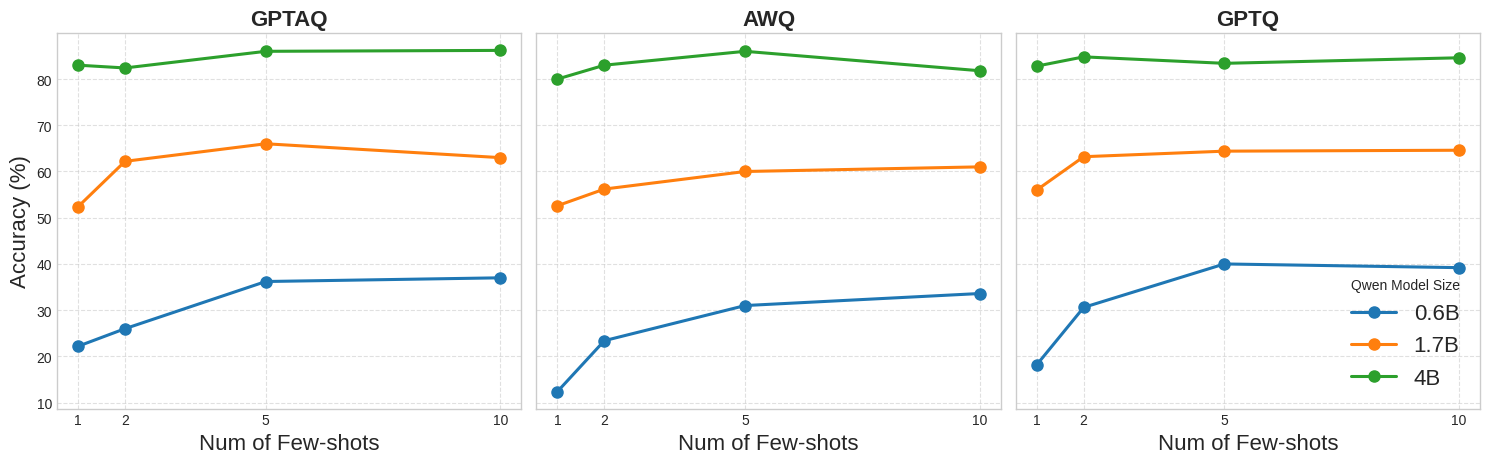

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data
fewshots = [1, 2, 5, 10]

GPTAQ = {
    '0.6B': [22.2, 26.0, 36.2, 37.0],
    '1.7B': [52.4, 62.2, 66.0, 63.0],
    '4B':   [83.0, 82.4, 86.0, 86.2]
}

AWQ = {
    '0.6B': [12.4, 23.4, 31.0, 33.6],
    '1.7B': [52.6, 56.2, 60.0, 61.0],
    '4B':   [80.0, 83.0, 86.0, 81.8]
}

GPTQ = {
    '0.6B': [18.2, 30.6, 40.0, 39.2],
    '1.7B': [56.0, 63.2, 64.4, 64.6],
    '4B':   [82.8, 84.8, 83.4, 84.6]
}

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

methods = [('GPTAQ', GPTAQ), ('AWQ', AWQ), ('GPTQ', GPTQ)]
colors = {'0.6B': '#1f77b4', '1.7B': '#ff7f0e', '4B': '#2ca02c'}

for ax, (name, data) in zip(axes, methods):
    for model_size, color in colors.items():
        ax.plot(fewshots, data[model_size], 
                marker='o', linewidth=2.2, markersize=8, 
                label=model_size, color=color)
    
    ax.set_title(name, fontsize=16, fontweight='bold')
    ax.set_xlabel('Num of Few-shots', fontsize=16)
    ax.set_xticks(fewshots)
    ax.grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Accuracy (%)', fontsize=16)
axes[-1].legend(title="Qwen Model Size", loc='lower right', fontsize=16)

# fig.suptitle('Evaluation of Quantization Methods on Different Qwen Model Sizes', fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


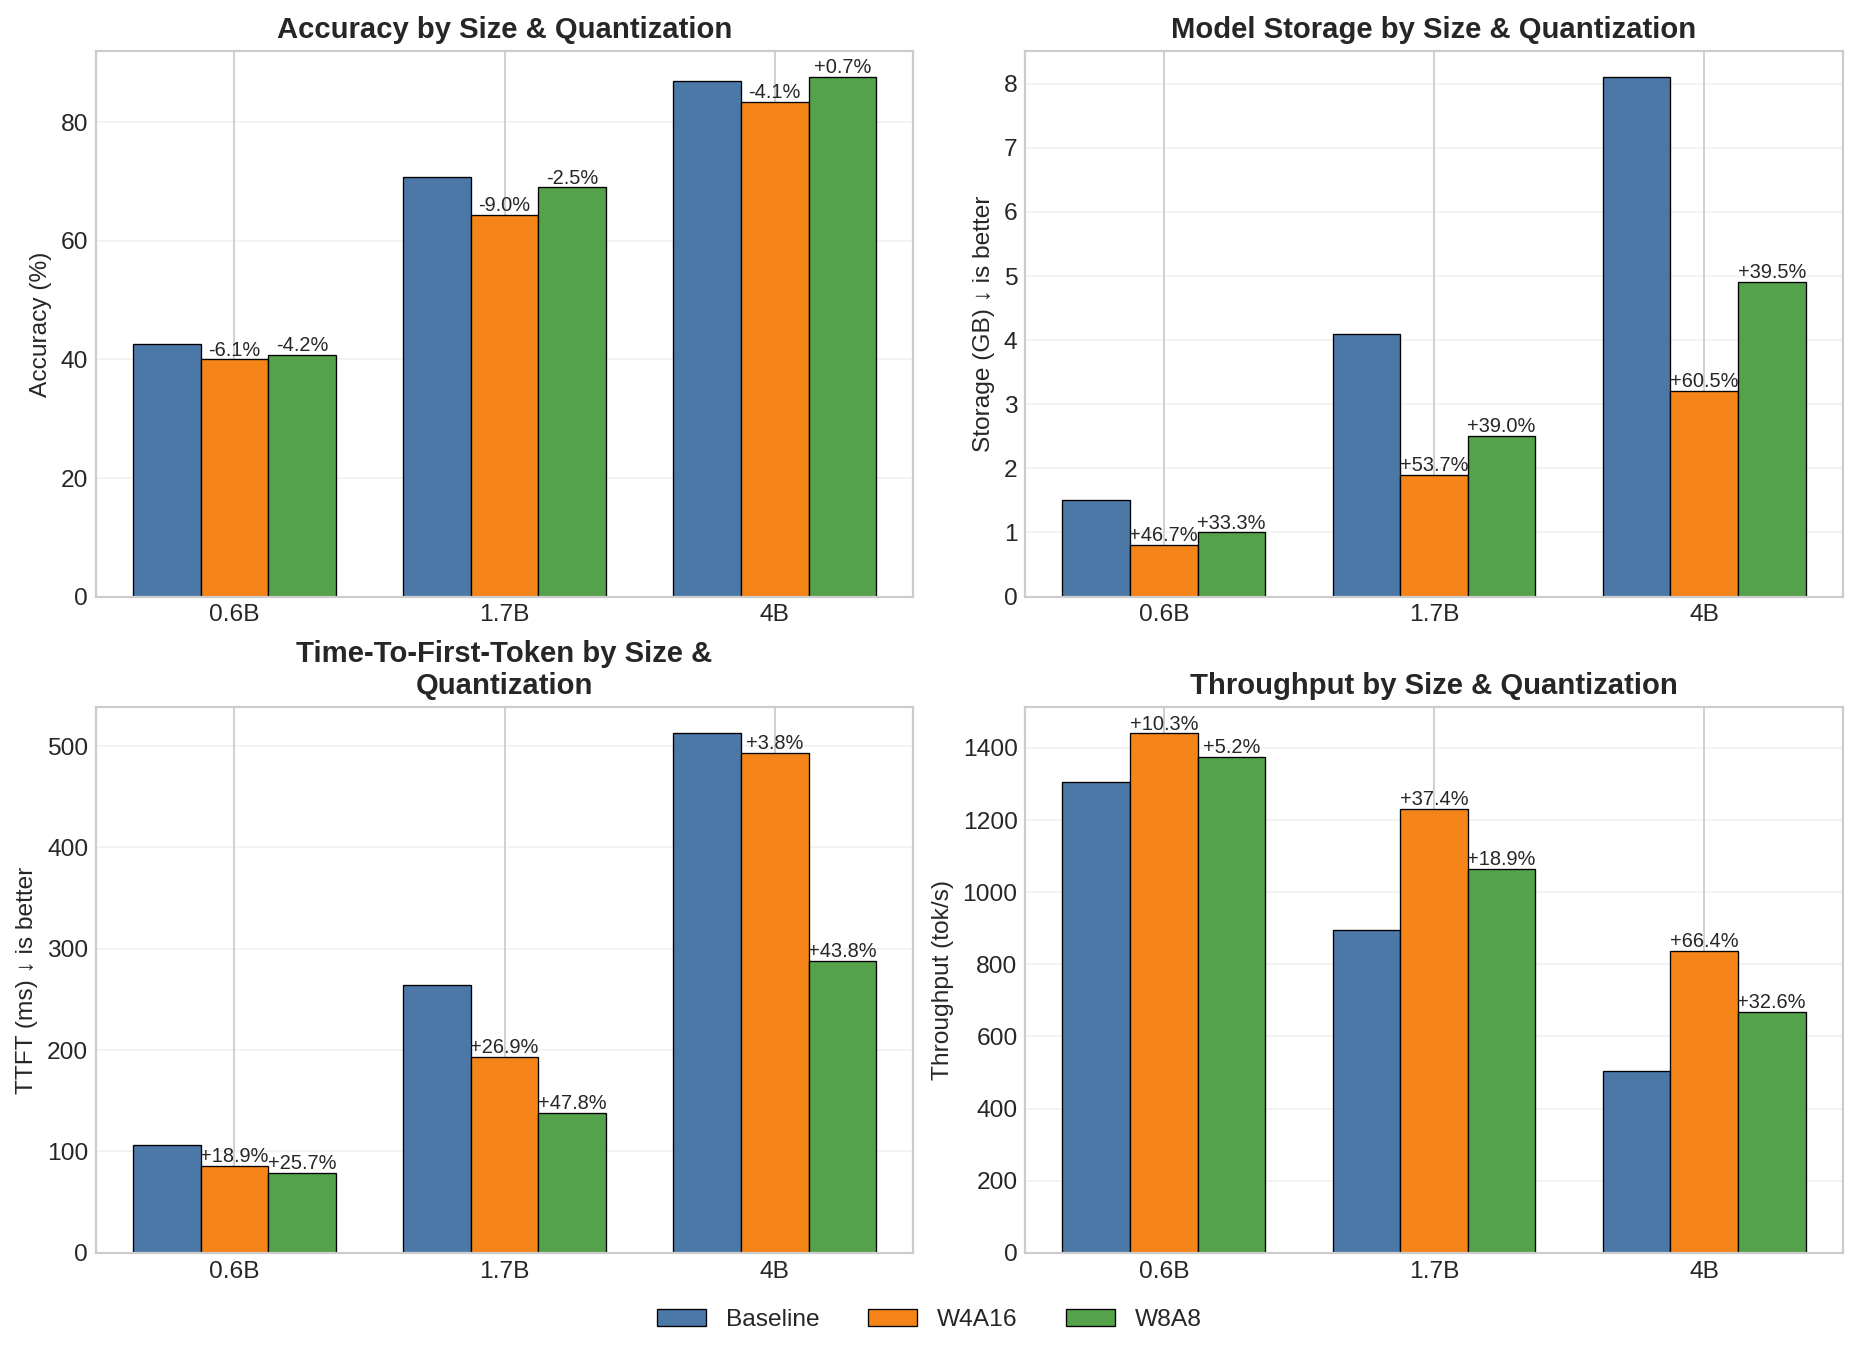

In [15]:
# 2x2 grid visualization for quantization results
# -----------------------------------------------
# Requirements: pandas, matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

# -----------------------------
# 1) Data (from your table)
# -----------------------------
rows = [
    ("0.6B", "Baseline", 42.6, 1.5, 106.0, 1306),
    ("0.6B", "W4A16",   40.0, 0.8,  86.0,  1440),
    ("0.6B", "W8A8",    40.8, 1.0,  78.8,  1374),

    ("1.7B", "Baseline", 70.8, 4.1, 263.8,  895),
    ("1.7B", "W4A16",   64.4, 1.9, 192.9,  1230),
    ("1.7B", "W8A8",    69.0, 2.5, 137.6,  1064),

    ("4B",   "Baseline", 87.0, 8.1, 512.4,  503),
    ("4B",   "W4A16",   83.4, 3.2, 492.8,   837),
    ("4B",   "W8A8",    87.6, 4.9, 288.0,   667),
]
df = pd.DataFrame(rows, columns=["Size", "Method", "Accuracy", "Storage_GB", "TTFT_ms", "Throughput"])

size_order   = ["0.6B", "1.7B", "4B"]
method_order = ["Baseline", "W4A16", "W8A8"]

# Optional: consistent colors
colors = {"Baseline": "#4c78a8", "W4A16": "#f58518", "W8A8": "#54a24b"}

# ------------------------------------------------
# 2) Helper: grouped bars + %Δ annotations
# ------------------------------------------------
def grouped_bar(ax, df, metric, ylabel, title, invert=False, annotate_delta=True):
    """
    invert=True for lower-is-better metrics (Storage, TTFT).
    %Δ vs Baseline is shown on quantized bars (+ better).
    """
    width = 0.25
    x = range(len(size_order))

    # Draw groups
    for i, m in enumerate(method_order):
        sub = df[df["Method"] == m].set_index("Size").loc[size_order]
        ax.bar([xi + (i-1)*width for xi in x],
               sub[metric].values,
               width=width,
               label=m,
               color=colors.get(m, None),
               edgecolor="black",
               linewidth=0.6)

    # Axes formatting
    ax.set_xticks([xi for xi in x], size_order)
    ax.set_ylabel(ylabel)
    ax.set_title("\n".join(wrap(title, 40)))
    ax.grid(axis="y", alpha=0.25)

    # %Δ vs Baseline annotations
    if annotate_delta:
        base = df[df["Method"] == "Baseline"].set_index("Size")
        for i, m in enumerate(method_order):
            if m == "Baseline":
                continue
            sub = df[df["Method"] == m].set_index("Size")
            for j, sz in enumerate(size_order):
                v = float(sub.loc[sz, metric])
                b = float(base.loc[sz, metric])
                change = (b - v)/b if invert else (v - b)/b  # + = improvement
                xpos = j + (i-1)*width
                ax.text(xpos, v,
                        f'{change*100:+.1f}%',
                        ha="center", va="bottom", fontsize=9)

# ------------------------------------------------
# 3) Build 2×2 grid
# ------------------------------------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.titleweight": "semibold",
    "axes.labelweight": "regular",
})

fig, axes = plt.subplots(2, 2, figsize=(11.5, 8), dpi=160, constrained_layout=True)
(ax_acc, ax_mem), (ax_ttft, ax_tp) = axes

grouped_bar(ax_acc, df, "Accuracy",    "Accuracy (%)",            "Accuracy by Size & Quantization", invert=False)
grouped_bar(ax_mem, df, "Storage_GB",  "Storage (GB) ↓ is better","Model Storage by Size & Quantization", invert=True)
grouped_bar(ax_ttft, df, "TTFT_ms",    "TTFT (ms) ↓ is better",   "Time-To-First-Token by Size & Quantization", invert=True)
grouped_bar(ax_tp,  df, "Throughput",  "Throughput (tok/s)",      "Throughput by Size & Quantization", invert=False)

# Shared legend centered under the grid
handles, labels = ax_acc.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=3, frameon=False, bbox_to_anchor=(0.5, -0.05))

# fig.suptitle("Quantization Trade-offs Across Model Sizes", y=1.02, fontsize=14, fontweight="bold")
fig.savefig("quantization_2x2.png", bbox_inches="tight")
plt.show()


In [ ]:
,